In [50]:
########################################
# Bike Sharing Assignment Notebook
# Topic - Linear Regression
########################################

# =============================
# 1. Import Libraries
# =============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For splitting, metrics, and regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# =============================
# 2. Load the Data
# =============================
# Replace 'day.csv' with your file path if necessary
df = pd.read_csv('/content/sample_data/day.csv')
# Quick inspection
print("Dataframe shape:", df.shape)
df.head()


Dataframe shape: (730, 16)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [51]:
# =============================
# 3. Data Inspection & Cleaning
# =============================
# Basic Info
df.info()
df.describe()

# Check for duplicates
df.duplicated().sum()

# Check for null values
print("Missing values per column:\n", df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB
Missing values per column:
 instant       0
dteday        0
season        0
yr            0
m

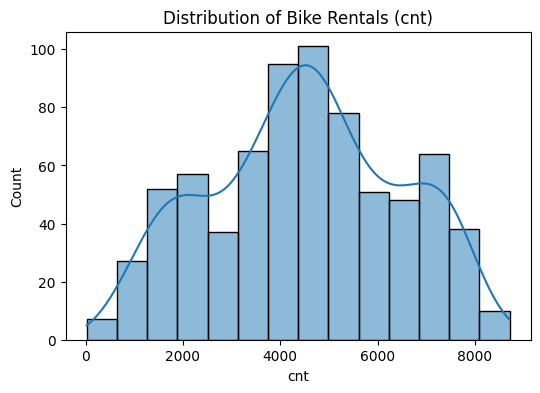

In [52]:
# =============================
# 4. Exploratory Data Analysis (EDA)
# =============================

# Distribution of Target Variable (cnt)
plt.figure(figsize=(6,4))
sns.histplot(df['cnt'], kde=True)
plt.title('Distribution of Bike Rentals (cnt)')
plt.show()

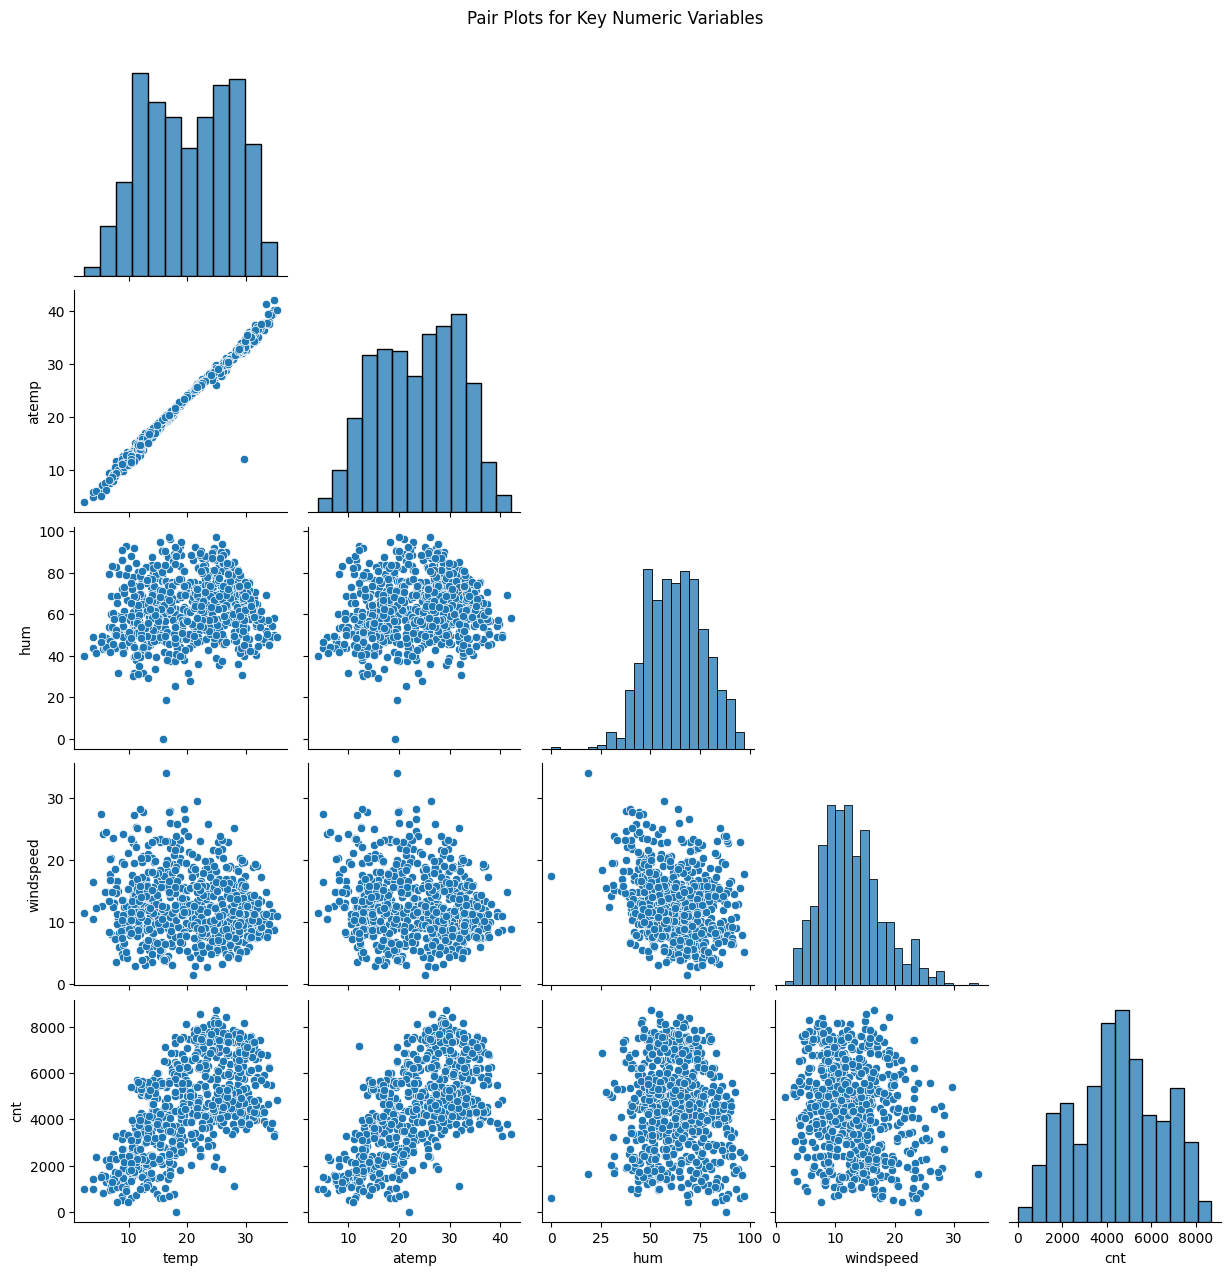

In [53]:
# Pair Plots for Key Numeric Features
numeric_cols = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
sns.pairplot(df[numeric_cols], corner=True)
plt.suptitle("Pair Plots for Key Numeric Variables", y=1.02)
plt.show()

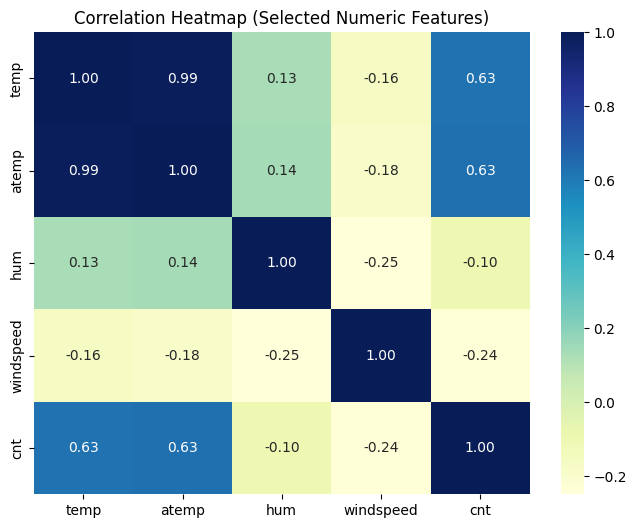

In [54]:
# Correlation Heatmap among Numeric Features
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Correlation Heatmap (Selected Numeric Features)')
plt.show()

In [55]:
# =============================
# 5. Data Preprocessing
# =============================

# Convert season & weathersit to their descriptive string labels
df['season'] = df['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
df['weathersit'] = df['weathersit'].map({
    1:'clear',
    2:'mist_cloudy',
    3:'light_snow_rain',
    4:'heavy_rain'
})

# Convert these newly string-labeled columns to dummy variables
df = pd.get_dummies(df, columns=['season', 'weathersit'], drop_first=True)

# Drop columns that aren't needed for the regression
# 'instant' - index, 'dteday' - date string, 'casual'/'registered' - components of 'cnt'
df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1, inplace=True)

# Verify the columns left
print("\nColumns after dropping unnecessary ones:\n", df.columns)

# Double-check data types
print("\nData types after creating dummy variables:")
print(df.dtypes)


Columns after dropping unnecessary ones:
 Index(['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'temp', 'atemp',
       'hum', 'windspeed', 'cnt', 'season_spring', 'season_summer',
       'season_winter', 'weathersit_light_snow_rain',
       'weathersit_mist_cloudy'],
      dtype='object')

Data types after creating dummy variables:
yr                              int64
mnth                            int64
holiday                         int64
weekday                         int64
workingday                      int64
temp                          float64
atemp                         float64
hum                           float64
windspeed                     float64
cnt                             int64
season_spring                    bool
season_summer                    bool
season_winter                    bool
weathersit_light_snow_rain       bool
weathersit_mist_cloudy           bool
dtype: object


In [59]:
# =============================
# 6. Train-Test Split
# =============================
X = df.drop('cnt', axis=1)
y = df['cnt']

# 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=42
)

print(f"\nTraining set size: {X_train.shape}, {y_train.shape}")
print(f"Test set size: {X_test.shape}, {y_test.shape}")


Training set size: (510, 14), (510,)
Test set size: (220, 14), (220,)


In [70]:
# =============================
# 7. Build OLS Model (Statsmodels)
# =============================

# Check that X_train is purely numeric
print("\nX_train dtypes before OLS:")
print(X_train.dtypes)

# Convert boolean to int
X_train = X_train.astype({col: int for col in X_train.select_dtypes(include=['bool']).columns})
X_test = X_test.astype({col: int for col in X_test.select_dtypes(include=['bool']).columns})

# Add constant
X_train_sm = sm.add_constant(X_train)

# Fit the OLS model
lr_sm = sm.OLS(y_train, X_train_sm).fit()

print("\nOLS Model Summary (Initial):")
print(lr_sm.summary())


X_train dtypes before OLS:
yr                              int64
mnth                            int64
holiday                         int64
weekday                         int64
workingday                      int64
temp                          float64
atemp                         float64
hum                           float64
windspeed                     float64
season_spring                   int64
season_summer                   int64
season_winter                   int64
weathersit_light_snow_rain      int64
weathersit_mist_cloudy          int64
dtype: object

OLS Model Summary (Initial):
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     166.5
Date:                Sat, 22 Feb 2025   Prob (F-statistic):          6.09e-177
T

In [75]:
# =============================
# 8. Check Multicollinearity (VIF)
# =============================
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_train.values, i)
    for i in range(X_train.shape[1])
]
print("\nVariance Inflation Factors:")
print(vif_data)


# Drop iteration -1 : dropping atemp due to high vif
X_train.drop('atemp', axis=1, inplace=True)



Variance Inflation Factors:
                       Feature        VIF
0                           yr   2.108761
1                         mnth  14.174722
2                      holiday   1.114885
3                      weekday   3.083279
4                   workingday   3.215364
5                         temp  19.687850
6                          hum  29.879342
7                    windspeed   7.066858
8                season_spring   3.903042
9                season_summer   2.460480
10               season_winter   3.972547
11  weathersit_light_snow_rain   1.265742
12      weathersit_mist_cloudy   2.235233


KeyError: "['atemp'] not found in axis"

In [76]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_train.values, i)
    for i in range(X_train.shape[1])
]
print("\nVariance Inflation Factors:")
print(vif_data)


Variance Inflation Factors:
                       Feature        VIF
0                           yr   2.108761
1                         mnth  14.174722
2                      holiday   1.114885
3                      weekday   3.083279
4                   workingday   3.215364
5                         temp  19.687850
6                          hum  29.879342
7                    windspeed   7.066858
8                season_spring   3.903042
9                season_summer   2.460480
10               season_winter   3.972547
11  weathersit_light_snow_rain   1.265742
12      weathersit_mist_cloudy   2.235233


In [77]:
#iteration 2: dropping off humidity as it may correlate with temp and season
X_train.drop('hum', axis=1, inplace=True)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_train.values, i)
    for i in range(X_train.shape[1])
]
print("\nVariance Inflation Factors:")
print(vif_data)


Variance Inflation Factors:
                       Feature        VIF
0                           yr   2.092800
1                         mnth  12.825977
2                      holiday   1.114181
3                      weekday   3.078222
4                   workingday   3.210142
5                         temp  11.655943
6                    windspeed   7.019658
7                season_spring   2.326811
8                season_summer   2.080694
9                season_winter   3.626314
10  weathersit_light_snow_rain   1.090698
11      weathersit_mist_cloudy   1.570860


In [78]:
#iteration 3: Mnth may be correlated to season which in turn to temp. So dropping it off
X_train.drop('mnth', axis=1, inplace=True)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_train.values, i)
    for i in range(X_train.shape[1])
]
print("\nVariance Inflation Factors:")
print(vif_data)


Variance Inflation Factors:
                       Feature       VIF
0                           yr  2.088559
1                      holiday  1.105162
2                      weekday  3.050508
3                   workingday  3.208217
4                         temp  6.905063
5                    windspeed  6.866455
6                season_spring  2.284931
7                season_summer  1.954178
8                season_winter  1.805526
9   weathersit_light_snow_rain  1.086812
10      weathersit_mist_cloudy  1.555892


Temp and widspeed may be good features. Hence not dropping off for now

In [79]:
# =============================
# 9. Model & Evaluation
# =============================
# evaluate the current model on the test set

# Add constant to test set
X_test_sm = sm.add_constant(X_test)
y_pred_sm = lr_sm.predict(X_test_sm)

# Evaluate
r2_test = r2_score(y_test, y_pred_sm)
mse_test = mean_squared_error(y_test, y_pred_sm)
rmse_test = np.sqrt(mse_test)

print("\nTest R-squared (Statsmodels):", r2_test)
print("Test RMSE (Statsmodels):", rmse_test)



Test R-squared (Statsmodels): 0.8292724326687159
Test RMSE (Statsmodels): 794.6407889773603


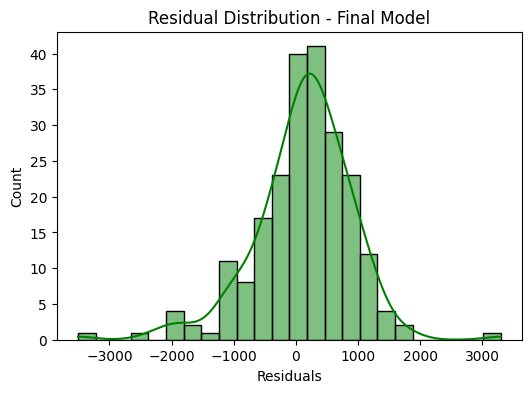

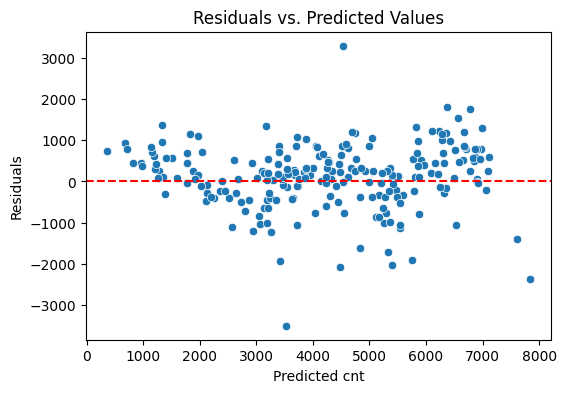

In [81]:
# =============================
# 11. Residual Analysis
# =============================
residuals = y_test - y_pred_sm

plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, color='green')
plt.title("Residual Distribution - Final Model")
plt.xlabel("Residuals")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred_sm, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted cnt")
plt.ylabel("Residuals")
plt.show()

In [82]:
# =============================
# 12. Conclusion
# =============================
print(f"\nFinal Model R-squared on Test Set: {r2_test:.4f}")
print(f"Final RMSE on Test Set: {rmse_test:.2f}")
print("\n--- END OF NOTEBOOK ---")


Final Model R-squared on Test Set: 0.8293
Final RMSE on Test Set: 794.64

--- END OF NOTEBOOK ---
